# Prediction of aging parameters for partial data window

In [8]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
plt.style.use('seaborn-white')

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [9]:
parameter_values = get_parameter_values()

In [10]:
# parameter_values.search("Li")

In [11]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [12]:
cell = 1

## Load eSOH Data and OCV Data

In [13]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339
11
Reversible Expansion
Irreversible Expansion


In [14]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [ ]:
Temp

In [ ]:
print(5e-3/3600)
print(4.3e-2/3600)

In [ ]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        # "Positive electrode LAM constant proportional term [s-1]": 5*5e-3/3600,
        # "Negative electrode LAM constant proportional term [s-1]": 5*4.3e-2/3600,
        "Positive electrode LAM constant proportional term [s-1]": 1e-7,
        "Negative electrode LAM constant proportional term [s-1]": 1e-6,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        # "EC diffusivity [m2.s-1]": 8.30909086e-19,
        # "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "EC diffusivity [m2.s-1]": 2e-18,
        "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [ ]:
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [ ]:
# fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [ ]:
# fgdfdfg

# Parameter Fitting

In [34]:
cycles = np.array(dfe['N'].astype('int'))
cycles=cycles-1
cycles[0]=cycles[0]+1
cycles
dfe['N_mod'] = cycles
N_mod=cycles

In [ ]:
# dfe

In [ ]:
def plot_comp(all_sumvars_dict_0,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict_0["Cycle number"],all_sumvars_dict_0[name],"ro")
        # ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.axvline(x = all_sumvars_dict_0["Cycle number"][-1], color = 'm', label = 'axvline - full height')
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Train"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5, -0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

## List of Initial Conditions

In [ ]:
ic = 0
blam_p = [1e-6,1e-7,1/5*8e-7]
blam_n = [1e-5,1e-6,1/2*5.5e-6]
k_sei= [1*2e-16,1/5*2e-16,5*2e-16]

In [ ]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt,ic):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, expt, SOC_0,save_at_cycles=1)
def prediction_error(x,data,expt,ic):
    try:
        model = simulate(x,expt,ic,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt,ic):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt,ic), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len,ic):
    data_train = dfe.iloc[:train_len]
    # experiment_train = pybamm.Experiment(
    #     [
    #         ("Discharge at "+c_rate_d+dis_set,
    #         "Rest for 5 min",
    #         "Charge at "+c_rate_c+" until 4.2V", 
    #         "Hold at 4.2V until C/50")
    #     ] *data_train.N.iloc[-1],
    #     termination="50% capacity",
    # #     cccv_handling="ode",
    # )
    experiment_train=experiment
    soln_dfols = train_model(data_train,experiment_train,ic)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][0]=train_len
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    # df['obj'][0]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,ic,timeout = 60)
        # sol_full = simulate(soln_dfols.x,experiment,ic,timeout = 60)
        print('err 0')
        df['obj'][0]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train,ic))
        print('err 1')
        # df['obj_full'][0] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment,ic))
        # print('err 2')
        fig = plot_comp(sol_out,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [ ]:
df_x = pd.DataFrame(columns=['train_len','x_0','x_1','obj'], index=range(1))

In [ ]:
sim_des = "old_cell_"+cell_no
print(sim_des)

In [ ]:
# sim_des = "cell_"+cell_no
timer1 = pybamm.Timer()
train_len = len(N)
# for ic in range(0,3):
for ic in [0]:
    print("Initial Condition = {0}".format(ic))
    df_x,fig = sim_train(dfe,experiment,df_x,train_len,ic)
    df_x.to_csv(res_DIR + "fit_train_beta_"+sim_des+'_ic'+str(ic)+".csv", index=False)
    fig.suptitle('Cell No = '+cell_no,fontsize=16,y=1.02)
    fig.savefig(fig_DIR + "fit_train_beta_"+ sim_des+'_ic'+str(ic)+"_eSOHC.png",bbox_inches='tight')
    print('Total Time')
    print(timer1.time())

In [ ]:
adasdasd

## Results

In [ ]:
sim_des

In [ ]:
df_x['x_0']

In [ ]:
df_x

## Compare

In [15]:
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 4.0647e-06,
        "Negative electrode LAM constant proportional term [s-1]": 5.2436e-05,
        # "Positive electrode LAM constant proportional term [s-1]": 7.043e-07,
        # "Negative electrode LAM constant proportional term [s-1]": 9.856e-06,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        # "EC diffusivity [m2.s-1]": 8.30909086e-19,
        # "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "EC diffusivity [m2.s-1]": 2e-18,
        "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)

In [16]:
all_sumvars_dict1 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [17]:
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 3.8498e-06,
        "Negative electrode LAM constant proportional term [s-1]": 5.0945e-05,
        # "Positive electrode LAM constant proportional term [s-1]": 6.85e-07,
        # "Negative electrode LAM constant proportional term [s-1]": 9.862e-06,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)

In [18]:
all_sumvars_dict2 = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

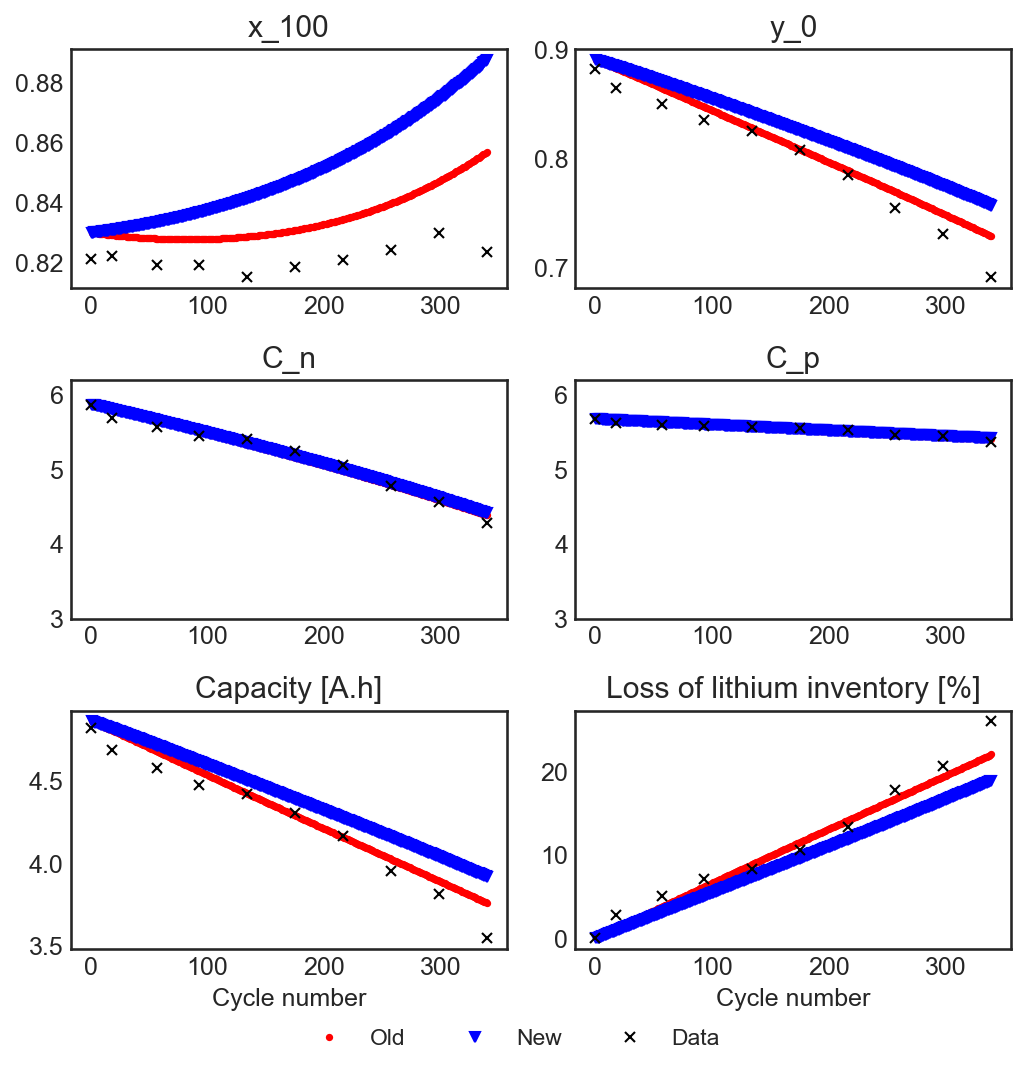

In [45]:
fig = plotc2(all_sumvars_dict1,all_sumvars_dict2,dfe);
fig.savefig(fig_DIR +'comp_sei_cyling_'+cell_no+'.png')

In [27]:
def plotc2(all_sumvars_dict1,all_sumvars_dict2,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"r.")
        ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"bv")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k ==2 or k==3:
            ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Old", "New" , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.03], ncol=3, fontsize=11)
    fig.tight_layout()
    return fig


In [21]:
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)

In [32]:
def voltage_sim(cyc_no,N,eSOH,SOC_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    try:
        print('sim')
        print(int(N[cyc_no]))
        Cn = eSOH["C_n"][N[cyc_no]]
        print(Cn)
        Cp = eSOH["C_p"][N[cyc_no]]
        print(Cp)
        n_Li_init = eSOH["Total lithium in particles [mol]"][N[cyc_no]]
        print(n_Li_init)
    except:
        print('data')
        Cn = eSOH["C_n"][cyc_no]
        Cp = eSOH["C_p"][cyc_no]
        n_Li_init = eSOH["n_Li"][cyc_no]  
    c_n_max = parameter_values.evaluate(param.n.c_max)
    c_p_max = parameter_values.evaluate(param.p.c_max)      
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    # if max(Q)<max(SOC_data['Q']):
    #     int_V = interpolate.CubicSpline(SOC_data['Q'],SOC_data['V'],extrapolate=True)
    #     rmse_V = pybamm.rmse(Vt,int_V(Q))
    #     V_err = Vt-int_V(Q)
    #     max_V = abs(V_err[-2])
    #     V_max_loc = np.argmax(abs(V_err))
    #     V_err_Q = Q[V_max_loc]
    #     V_err_max = V_err[V_max_loc]
    #     Q_err = Q
    # else:
    int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
    rmse_V = pybamm.rmse(SOC_data['V'],int_V(SOC_data['Q']))
    V_err = int_V(SOC_data['Q'])-SOC_data['V']
    max_V = abs(V_err.iloc[-2])
    V_max_loc = np.argmax(abs(V_err))
    V_err_Q = SOC_data['Q'].iloc[V_max_loc]
    V_err_max = V_err.iloc[V_max_loc]
    Q_err = SOC_data['Q']
    return Q,Vt,rmse_V,max_V

In [43]:
results_dict = all_sumvars_dict1

sim
0
5.8711660903074705
5.6749611135726195
0.18896994059864666
sim
174
5.181456177137054
5.541194238488
0.17077859603511633
sim
338
4.414326307759638
5.418614407187488
0.15306844290269866


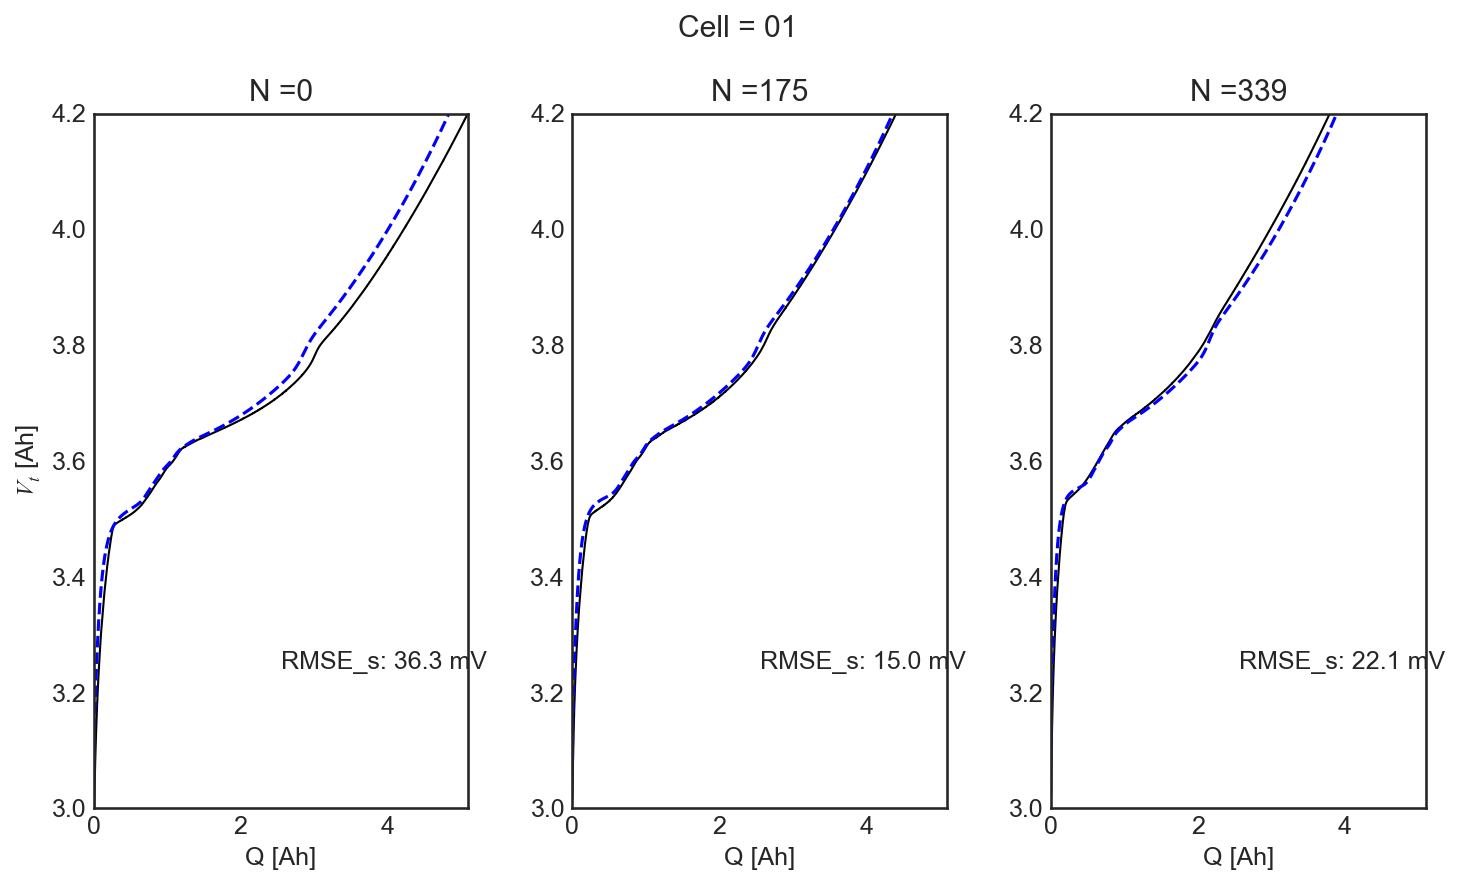

In [47]:
i = 0
rmse_V_l = []
max_V_l = []
fig, axes = plt.subplots(1,3,figsize=(10,6))
# for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
for cyc_no in range(len(N)):
# for cyc_no in [0]:
    # cyc_no=0
    # print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    # Q,Vt,exp,rmse_V,rmse_E,max_V,max_E = rev_exp(cyc_no,all_sumvars_dict,dfo)
    # Q_p,Vt_p,exp_p,rmse_V_p,rmse_E_p,max_V_p,max_E_p = rev_exp(cyc_no,dfe,dfo)
    # rmse_V_l = np.append(rmse_V_l,rmse_V)
    # rmse_E_l = np.append(rmse_E_l,rmse_E)
    # max_V_l = np.append(max_V_l,max_V)
    # max_E_l = np.append(max_E_l,max_E)
    if cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
        Q,Vt,rmse_V,max_V = voltage_sim(cyc_no,N_mod,all_sumvars_dict2,dfo)
        rmse_V_l = np.append(rmse_V_l,rmse_V)
        max_V_l = np.append(max_V_l,max_V)
        ax2 = axes.flat[i]
        ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
        ax2.plot(Q,Vt,'b--',linewidth=1.5)
        ax2.set_ylim([3,4.2])
        ax2.set_xlim([0,5.1])
        ax2.set_xlabel('Q [Ah]')
        ax2.set_title('N ='+str(N[cyc_no]))
        ax2.text(0.5,0.2,f'RMSE_s: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
        if i ==0:
            ax2.set_ylabel('$V_t$ [Ah]')
        i+=1
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'cyc_volt_comp_'+cell_no+'_2.png')